##### Setup

###### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import numpy as np
import matplotlib.pyplot as plt

from mlPlayGround.generative.vae import vaeEncoder, vaeDecoder, variationalAutoencoder, vqVariationalAutoencoder, autoencodingVariationalAutoencoder
from mlPlayGround.generative.rbm import restrictedBoltzmannMachine
from mlPlayGround.model import reshape

###### Load data

In [2]:
class imageOnlyDataset(torch.utils.data.Dataset):
    '''
    Class to extract only the images as do do not need labels to 
    train the generative models. 
    '''
    def __init__(self, original, index):
        self.__original = original
        self.__index = index

    @property
    def original(self):
        return self.__original

    @property
    def index(self):
        return self.__index

    def __len__(self):
        return len(self.original)

    def __getitem__(self, index):
        return self.original[index][self.index]

In [3]:
# ToTensor() scales eveything to [0, 1)
thresh = Lambda(lambda x: torch.where(ToTensor()(x) > 0.5, 1.0, 0.0))

# scatter_ to get a one-hot vector
onehot = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

trainData = datasets.MNIST(root="../data", train=True, download=True, transform=thresh, target_transform=onehot)
testData = datasets.MNIST(root="../data", train=False, download=True, transform=thresh, target_transform=onehot)
# trainData = datasets.MNIST(root="../data", train=True, download=True) # , transform=thresh, target_transform=onehot)

trainImageData = imageOnlyDataset(trainData, 0)  # remove the labels as we dont need them
testImageData = imageOnlyDataset(testData, 0)
print(len(trainData), len(testData), len(trainImageData), len(testImageData))

60000 10000 60000 10000


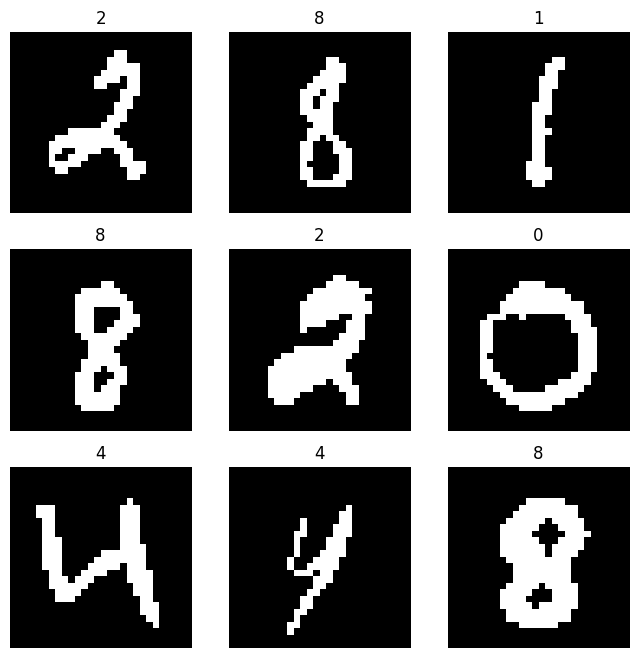

In [4]:
# show some randomly picked numbers
label_map = {k: str(k) for k in range(10)}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sidx = torch.randint(len(trainData), size=(1,)).item()
    img, label = trainData[sidx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[torch.argmax(label, dim=0).item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

###### Hardware Specs

In [5]:
cudaavailable = torch.cuda.is_available()
mpsavailable = torch.backends.mps.is_available()
curr_device = torch.cuda.current_device()

device = torch.device("cuda" if cudaavailable else "mps" if mpsavailable else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {cudaavailable}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda
Device count: 1
Device name: NVIDIA GeForce GTX 970


##### MNIST

###### Restricted Boltzmann Machine

In [6]:
# build the encoder and decoder networks
hid_dim = 64
model = restrictedBoltzmannMachine((1, 28, 28), hid_dim)

In [7]:
learning_rate = 1e-4
batch_size = 128
epochs = 50

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_rbm/',
                checkPointName='rbm_64',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
reconLoss: 181.411713 totalLoss: -9.050797 positiveLoss: -44.484169 negativeLoss: -35.433372[12800/60000]
reconLoss: 160.529099 totalLoss: -38.150505 positiveLoss: -57.207321 negativeLoss: -19.056818[25600/60000]
reconLoss: 142.857925 totalLoss: -57.041595 positiveLoss: -75.672325 negativeLoss: -18.630730[38400/60000]
reconLoss: 130.420074 totalLoss: -69.279099 positiveLoss: -87.410568 negativeLoss: -18.131472[51200/60000]
Validation Error: -75.206139
Epoch 2
-------------------------------
reconLoss: 119.509178 totalLoss: -77.852493 positiveLoss: -93.403053 negativeLoss: -15.550564[12800/60000]
reconLoss: 115.137833 totalLoss: -82.029266 positiveLoss: -95.954239 negativeLoss: -13.924971[25600/60000]
reconLoss: 112.280487 totalLoss: -84.428123 positiveLoss: -97.277420 negativeLoss: -12.849296[38400/60000]
reconLoss: 110.647362 totalLoss: -86.784592 positiveLoss: -96.992691 negativeLoss: -10.208097[51200/60000]
Validation Error: -90.617714
Epoch 3

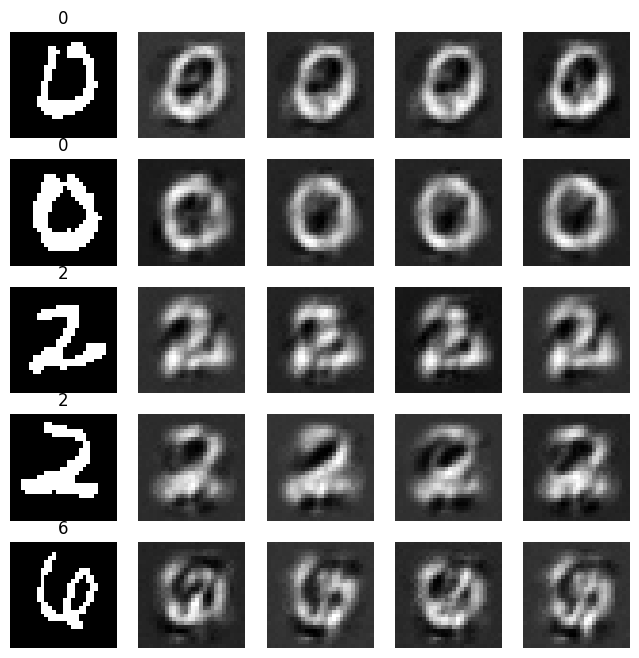

In [51]:
nimages, nsamples = 5, 4
figure = plt.figure(figsize=(8, 8))
model.eval()

for i in range(nimages):
    sidx = torch.randint(len(testData), size=(1,)).item()
    img, label = testData[sidx]
    
    n = i * (nsamples + 1) + 1
    figure.add_subplot(nimages, nsamples + 1, n)
    plt.title(label_map[torch.argmax(label, dim=0).item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    
    for j in range(1, nsamples + 1):
        n = i * (nsamples + 1) + j + 1
        smpl = model.reconstruct(img.unsqueeze(0))
        figure.add_subplot(nimages, nsamples + 1, n)
        plt.axis("off")
        plt.imshow(smpl.detach().squeeze(), cmap='gray')
        # plt.imshow(torch.where(smpl.squeeze() > 0.5, 1.0, 0.0), cmap='gray')  # thresholds the output
        
plt.show()

###### Variational Autoencoder

In [6]:
class mnistDecoder(vaeDecoder):
    @staticmethod
    def reconstructionLoss(x: torch.Tensor, recon: torch.Tensor) -> torch.Tensor:
        bce = torch.nn.functional.binary_cross_entropy(recon, x, reduction='none')
        return torch.mean(torch.sum(torch.flatten(bce, start_dim=1), dim=1))
        # return torch.mean(bce)

In [8]:
# build the encoder and decoder networks
hid_dim = 2

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))
encoder = vaeEncoder(encoder)

decoder = nn.Sequential(nn.Linear(hid_dim, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())
decoder = mnistDecoder(decoder)

model = variationalAutoencoder(encoder, decoder).to(device)

In [9]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_vae/',
                checkPointName='vae_2',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
totalLoss: 205.473007 reconLoss: 202.059113 klLoss: 3.413893[12800/60000]
totalLoss: 173.626556 reconLoss: 169.368637 klLoss: 4.257916[25600/60000]
totalLoss: 174.246948 reconLoss: 170.120193 klLoss: 4.126758[38400/60000]
totalLoss: 156.996246 reconLoss: 152.503281 klLoss: 4.492967[51200/60000]
Validation Error: 167.668472
Epoch 2
-------------------------------
totalLoss: 163.978226 reconLoss: 159.759735 klLoss: 4.218489[12800/60000]
totalLoss: 163.147156 reconLoss: 158.529205 klLoss: 4.617953[25600/60000]
totalLoss: 163.401352 reconLoss: 159.025085 klLoss: 4.376260[38400/60000]
totalLoss: 154.487808 reconLoss: 149.807251 klLoss: 4.680558[51200/60000]
Validation Error: 159.811707
Epoch 3
-------------------------------
totalLoss: 161.614120 reconLoss: 156.910278 klLoss: 4.703836[12800/60000]
totalLoss: 152.816254 reconLoss: 148.371414 klLoss: 4.444847[25600/60000]
totalLoss: 145.929550 reconLoss: 141.288284 klLoss: 4.641269[38400/60000]
totalLos

In [11]:
# inference
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

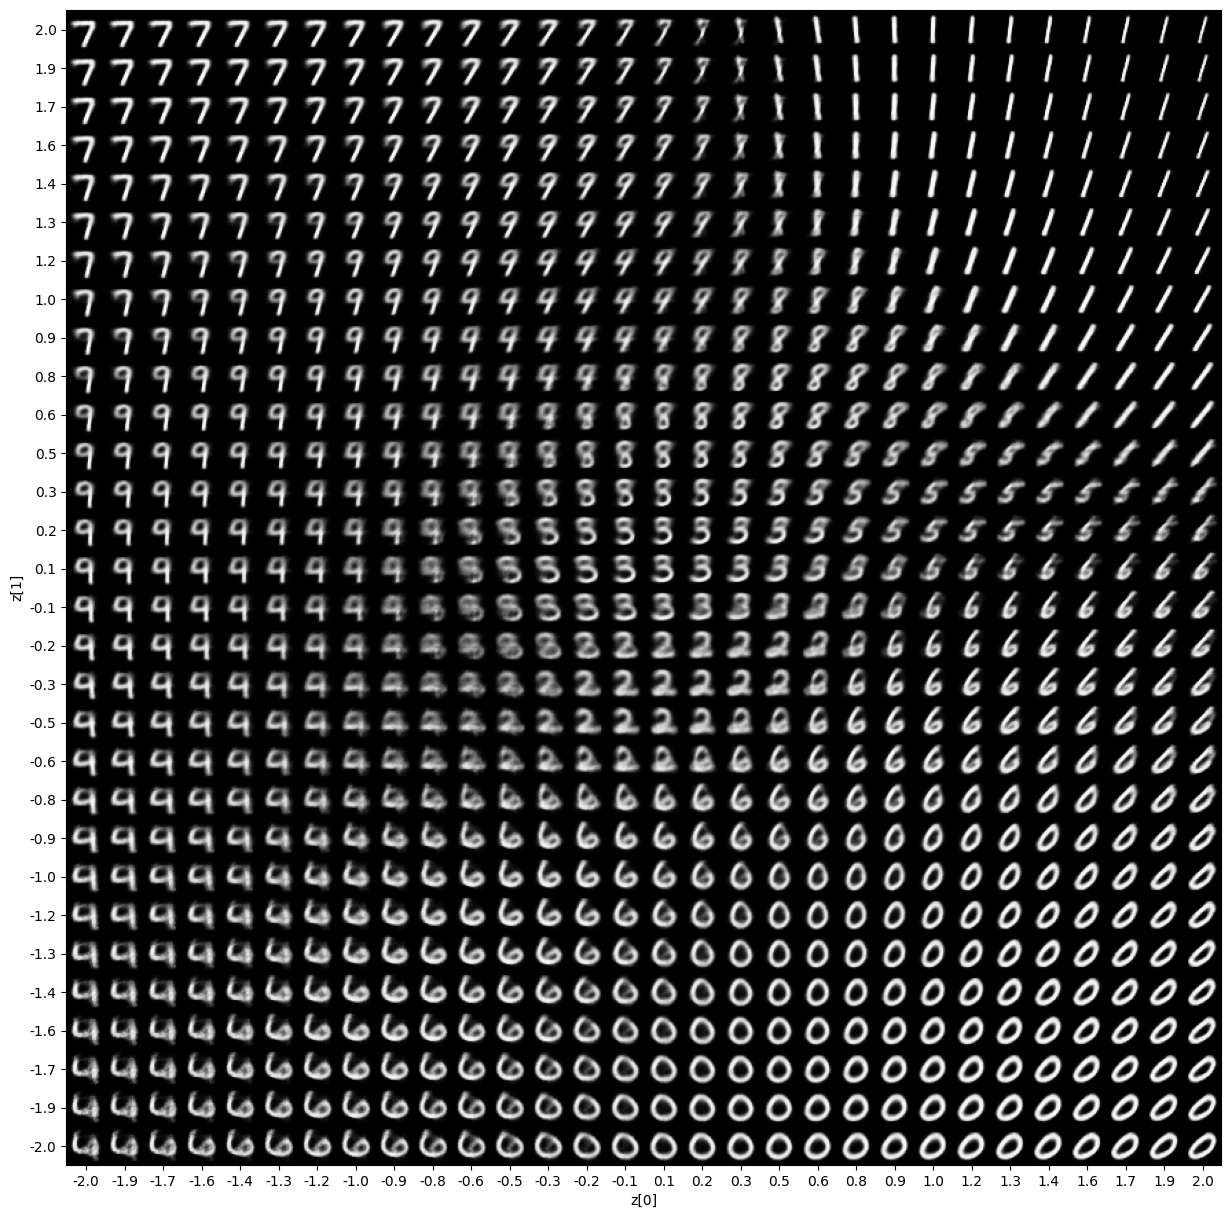

In [12]:
plot_latent_space(scale=2.0, n=30)

###### β-VAE

In [13]:
# build the encoder and decoder networks
hid_dim = 2
beta = 2.0

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))
encoder = vaeEncoder(encoder)

decoder = nn.Sequential(nn.Linear(hid_dim, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())
decoder = mnistDecoder(decoder)

model = variationalAutoencoder(encoder, decoder, beta).to(device)

In [14]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_bvae/',
                checkPointName='bvae_2_2',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
totalLoss: 206.139847 reconLoss: 200.661194 klLoss: 2.739329[12800/60000]
totalLoss: 185.769928 reconLoss: 179.695175 klLoss: 3.037376[25600/60000]
totalLoss: 175.202911 reconLoss: 168.772598 klLoss: 3.215159[38400/60000]
totalLoss: 175.354370 reconLoss: 169.096909 klLoss: 3.128728[51200/60000]
Validation Error: 172.762222
Epoch 2
-------------------------------
totalLoss: 167.575363 reconLoss: 160.843964 klLoss: 3.365700[12800/60000]
totalLoss: 177.550018 reconLoss: 171.391174 klLoss: 3.079426[25600/60000]
totalLoss: 171.170868 reconLoss: 165.051941 klLoss: 3.059463[38400/60000]
totalLoss: 163.219208 reconLoss: 156.692566 klLoss: 3.263320[51200/60000]
Validation Error: 164.821167
Epoch 3
-------------------------------
totalLoss: 159.507629 reconLoss: 152.520752 klLoss: 3.493440[12800/60000]
totalLoss: 159.771133 reconLoss: 153.239807 klLoss: 3.265661[25600/60000]
totalLoss: 154.834000 reconLoss: 147.734985 klLoss: 3.549505[38400/60000]
totalLos

In [16]:
# inference
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

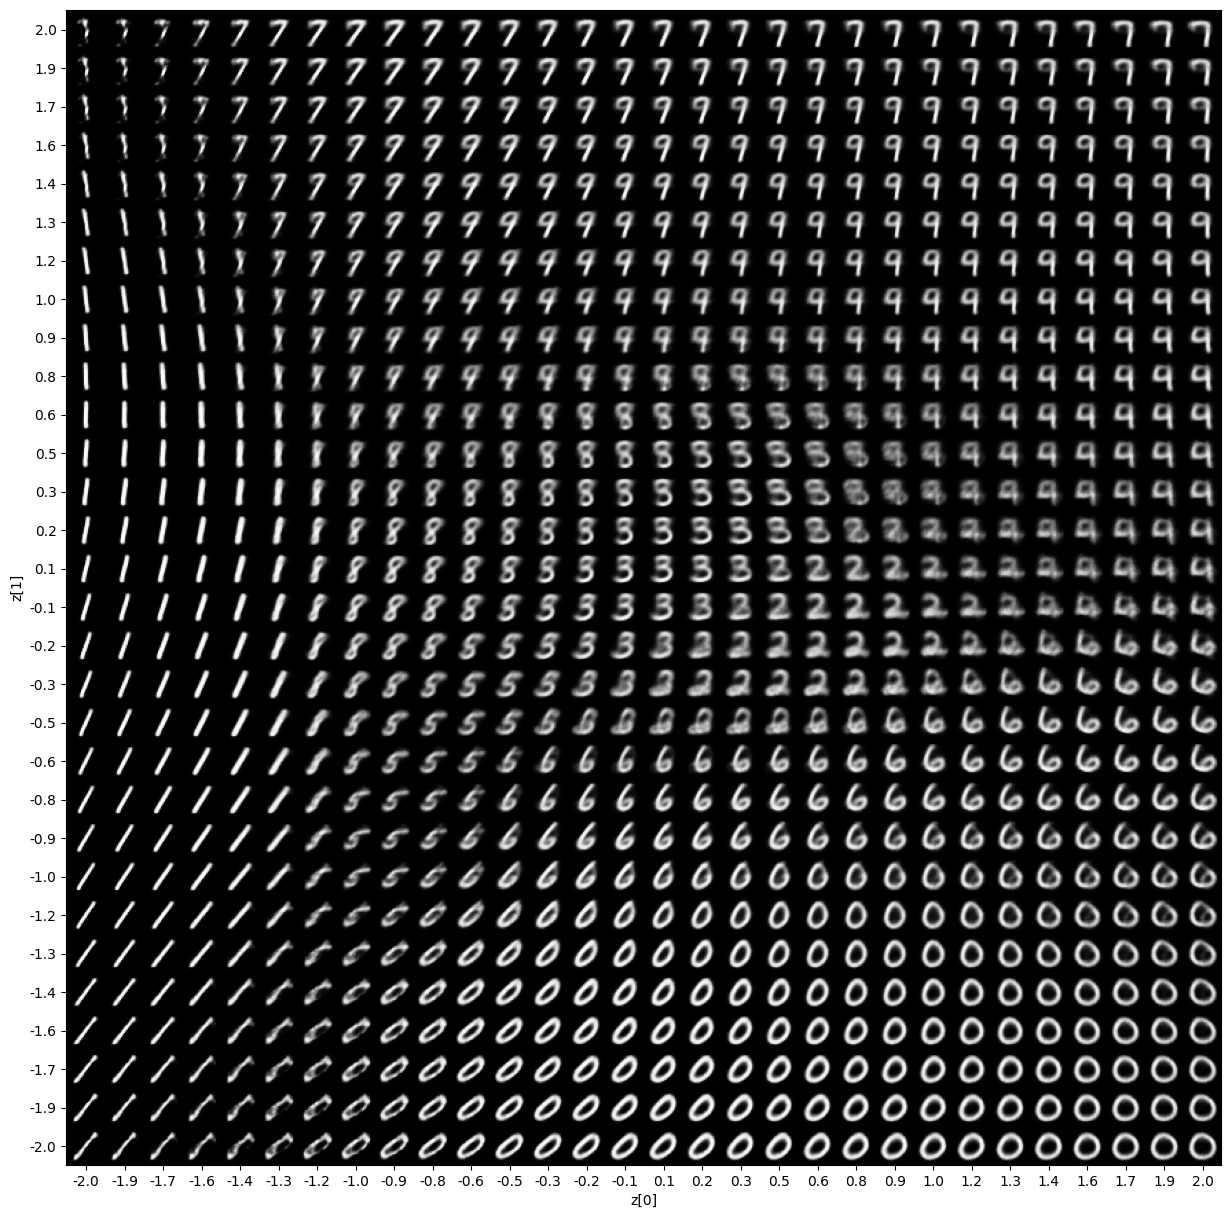

In [17]:
plot_latent_space(scale=2.0, n=30)

###### VQ-VAE

In [75]:
# build the encoder and decoder networks
hid_dim = 64
n_embeds = 16
beta = 1.
data_var = torch.var(torch.flatten(trainData.data).type(torch.DoubleTensor)) / 100

In [76]:
encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim))

decoder = nn.Sequential(nn.Linear(hid_dim, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())

model = vqVariationalAutoencoder(encoder, decoder, nDims=hid_dim, 
                                 nEmbeddings=n_embeds, beta=beta,
                                 data_var=1.).to(device)

In [77]:
learning_rate = 1e-3
batch_size = 64
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_vqvae/',
                checkPointName='vqvae_16_10')

Epoch 1
-------------------------------
totalLoss: 71.025299 reconLoss: 70.389938 codeLoss: 0.317683 commLoss: 0.317683 vqLoss: 0.635365[ 6400/60000]
totalLoss: 67.639755 reconLoss: 66.700424 codeLoss: 0.469662 commLoss: 0.469662 vqLoss: 0.939325[12800/60000]
totalLoss: 69.330711 reconLoss: 67.967613 codeLoss: 0.681547 commLoss: 0.681547 vqLoss: 1.363094[19200/60000]
totalLoss: 72.032677 reconLoss: 70.765907 codeLoss: 0.633386 commLoss: 0.633386 vqLoss: 1.266772[25600/60000]
totalLoss: 66.319839 reconLoss: 65.011398 codeLoss: 0.654218 commLoss: 0.654218 vqLoss: 1.308436[32000/60000]
totalLoss: 67.813850 reconLoss: 66.746361 codeLoss: 0.533748 commLoss: 0.533748 vqLoss: 1.067497[38400/60000]
totalLoss: 70.027908 reconLoss: 68.815445 codeLoss: 0.606229 commLoss: 0.606229 vqLoss: 1.212457[44800/60000]
totalLoss: 66.411346 reconLoss: 65.431366 codeLoss: 0.489989 commLoss: 0.489989 vqLoss: 0.979978[51200/60000]
totalLoss: 66.941757 reconLoss: 65.624695 codeLoss: 0.658533 commLoss: 0.658533 

In [ ]:
nCols = 4
nRows = n_embeds // nCols + (1 if n_embeds % nCols > 0 else 0)

figure = plt.figure(figsize=(8, 8))
model.eval()

for i in range(n_embeds):
    sidx = torch.randint(len(testData), size=(1,)).item()
    img, label = testData[sidx]
    
    figure.add_subplot(nRows, nCols, i + 1)
    plt.title(f'{i}')
    plt.axis("off")
    img = model.decode(model.vq.embeddings[:,i])[0,:,:,:]
    plt.imshow(img.cpu().detach().numpy().squeeze(), cmap='gray')

plt.show()

###### Autoencoding VAE

In [6]:
class mnistDecoder(vaeDecoder):
    @staticmethod
    def reconstructionLoss(x: torch.Tensor, recon: torch.Tensor) -> torch.Tensor:
        bce = torch.nn.functional.binary_cross_entropy(recon, x, reduction='none')
        return torch.mean(torch.sum(torch.flatten(bce, start_dim=1), dim=1))
        # return torch.mean(bce)

In [7]:
# build the encoder and decoder networks
hid_dim = 2

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))
encoder = vaeEncoder(encoder)

decoder = nn.Sequential(nn.Linear(hid_dim, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())
decoder = mnistDecoder(decoder)

model = autoencodingVariationalAutoencoder(encoder, decoder, rho=0.98).to(device)

In [8]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_avae/',
                checkPointName='avae_98',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
totalLoss: 205.386856 reconLoss: 197.618652 klLoss: 3.840798 condLoss: 3.927404[12800/60000]
totalLoss: 191.976883 reconLoss: 184.818970 klLoss: 3.985865 condLoss: 3.172047[25600/60000]
totalLoss: 185.626633 reconLoss: 178.507294 klLoss: 4.174019 condLoss: 2.945311[38400/60000]
totalLoss: 175.131409 reconLoss: 167.852509 klLoss: 4.471026 condLoss: 2.807873[51200/60000]
Validation Error: 172.873199
Epoch 2
-------------------------------
totalLoss: 172.901718 reconLoss: 165.792419 klLoss: 4.306739 condLoss: 2.802560[12800/60000]
totalLoss: 172.585907 reconLoss: 165.392609 klLoss: 4.451108 condLoss: 2.742193[25600/60000]
totalLoss: 170.120682 reconLoss: 162.798447 klLoss: 4.625353 condLoss: 2.696877[38400/60000]
totalLoss: 169.880600 reconLoss: 162.561447 klLoss: 4.581447 condLoss: 2.737707[51200/60000]
Validation Error: 165.342987
Epoch 3
-------------------------------
totalLoss: 157.291687 reconLoss: 149.929352 klLoss: 4.586903 condLoss: 2.77544

In [10]:
# inference
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

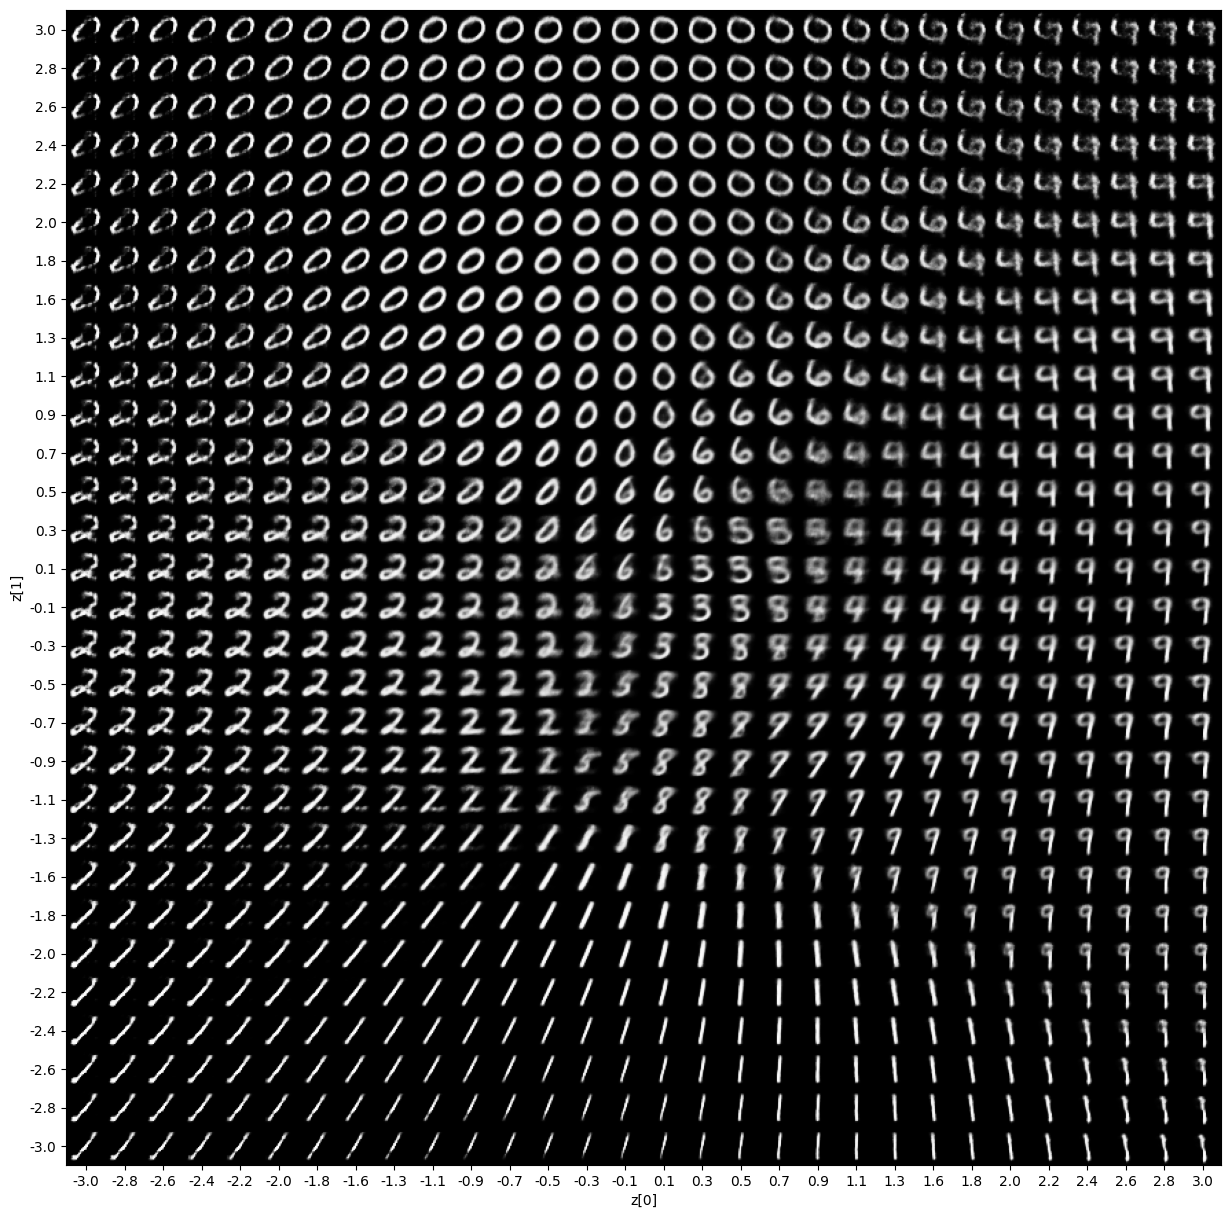

In [13]:
plot_latent_space(scale=3.0, n=30)